Dog Vs Cat Classification

1) Köpek ve kedi görüntülerini içeren veri seti indirilierek klasörlere aktarılır.

In [41]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2021-08-06 06:35:12--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.210.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  27.5MB/s    in 2.4s    

2021-08-06 06:35:15 (27.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [42]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import zipfile

In [43]:
local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

In [44]:
train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures


2) Veri sayısı az olduğu için farklı augmentation teknikleri kullanılarak veri sayısı artırılır. Görüntüler 2000 train, 500 validation ve 500 test için ayrılır. 

In [45]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

train_set = ImageFolder(train_dir, transform=train_transform)

val_test_set = ImageFolder(validation_dir, val_transform)

In [46]:
len(train_set)

2000

In [47]:

val_size = 1000-500

val_set, test_set = random_split(val_test_set, [val_size, 500])
len(val_set), len(test_set)

(500, 500)

3) Batch size 64 seçilir. Veriler uygun GPU olması durumunda modelin GPU üzerinde daha hızlı eğitilmesi sağlanır.

In [48]:
batch_size=16

train_set = DataLoader(train_set, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_set = DataLoader(val_set, batch_size*2, num_workers=3, pin_memory=True)
test_set = DataLoader(test_set, batch_size*2, num_workers=3, pin_memory=True)


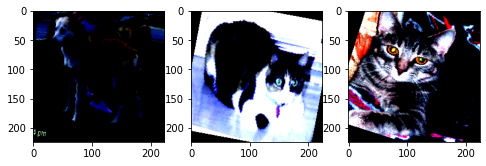

In [49]:
for images, labels in train_set:
    
    plt.figure(figsize=(8,8))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(images[0].permute(1, 2, 0))
    ax = plt.subplot(1, 3, 2)
    plt.imshow(images[1].permute(1, 2, 0))
    ax = plt.subplot(1, 3, 3)
    plt.imshow(images[2].permute(1, 2, 0))
    plt.show()
    
    break

3) Modelde dropout kullanılarak overfiting engellenmeye çalışılmıştır. Veri setinde 2 farklı sınıf bulunduğu için son katmanda çıkış 2 seçilmiştir. 

In [50]:
   
class Model(nn.Module):   
  def __init__(self):
      super(Model, self).__init__()
      self.cnnlayers = nn.Sequential(
          
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Dropout(0,4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0,),
          
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Dropout(0,4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0,),
          
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Dropout(0,4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0,),
          
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Dropout(0,4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0,),
          
      )
          
      self.fc = nn.Sequential(
            nn.Linear(50176, 128),
            # Overfiting engellenmesi icin dropout kullanildi.
            nn.Dropout(0,5),
            nn.ReLU(inplace=True),
            # Veri setinde 2 sinif bulundugu icin cikis 2 yapildi.
            nn.Linear(128, 2)
      )
        
    
  def forward(self, x):
        
        x = self.cnnlayers(x)
        x = x.view(x.size(0), -1)
        #print((x.shape))
        x = self.fc(x)
        
        return x

model=Model()


4)Uygun GPU kontrolü yapılır. Yoksa CPU üzerinden eğitim yapılır.

In [51]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [52]:
model.to(device)

Model(
  (cnnlayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Dropout(p=0, inplace=4)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Dropout(p=0, inplace=4)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Dropout(p=0, inplace=4)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Dropout(p=0, inplace=4)
    (16): ReLU()
    (17): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0)

5) Model çıkışında 2 farklı sınıf bulunduğu için CrossEntropyLoss kullanıldı. Learning rate model eğitimiyle birlikte azaltılarak daha iyi performans elde edilmeye çalışıldı.

In [53]:
number_of_epoch=30
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

decayRate = 0.90
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [54]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

6) fit fonksiyonu ile her epoch içerisinde tüm batchler için eğitim yapılır. Veriler device'a aktarılarak GPU ile daha hızlı eğitim yapılır. Model eğitiminde kayıplar hesaplanarak back propagation hesaplanır ve ağırlıklar değiştirilir. Her epoch için kayıp ve doğruluk değerleri yazdırılır.

In [55]:

def fit(model,number_of_epoch,criterion,train_set,val_set,optimizer=torch.optim.Adam):
    
    history=[]
    
    for epoch in range(number_of_epoch):
        epoch_acc=0
        epoch_loss=0
        val_epoch_acc=0
        val_epoch_loss=0
        for img,lbl in train_set:
            
            img, lbl = img.to(device), lbl.to(device)
            #lbl=lbl.unsqueeze(1)
            output = model(img)
            loss = criterion(output, lbl)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            acc = accuracy(output, lbl)
            epoch_acc += acc.item()/len(train_set)
            epoch_loss += loss.item()/len(train_set)
            
        for val_img,val_lbl in val_set:
            val_img, val_lbl = val_img.to(device), val_lbl.to(device)
            #val_lbl=val_lbl.unsqueeze(1)
            val_output = model(val_img)
            val_loss = criterion(val_output, val_lbl)
            val_acc = accuracy(val_output, val_lbl)
            
            val_epoch_acc += val_acc.item()/len(val_set)
            val_epoch_loss += val_loss.item()/len(val_set)
            
        lr_scheduler.step()
        result={'loss': epoch_loss, 'acc': epoch_acc,
            'val_loss': val_epoch_loss, 'val_acc': val_epoch_acc}

        print("Epoch {}/{} , loss: {:.4f}, acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1,number_of_epoch,result['loss'], result['acc'], result['val_loss'], result['val_acc']))

        history.append(result)
    return history

In [56]:
torch.cuda.empty_cache()
history=fit(
    model,
    number_of_epoch,
    criterion,
    train_set,
    val_set,
    optimizer,
)

Epoch 1/30 , loss: 0.6934, acc: 0.5020, val_loss: 0.6777, val_acc: 0.5785
Epoch 2/30 , loss: 0.6789, acc: 0.5605, val_loss: 0.6491, val_acc: 0.6156
Epoch 3/30 , loss: 0.6421, acc: 0.6350, val_loss: 0.6040, val_acc: 0.6586
Epoch 4/30 , loss: 0.6083, acc: 0.6815, val_loss: 0.5991, val_acc: 0.6508
Epoch 5/30 , loss: 0.5893, acc: 0.6920, val_loss: 0.5735, val_acc: 0.6797
Epoch 6/30 , loss: 0.5722, acc: 0.7190, val_loss: 0.5584, val_acc: 0.7105
Epoch 7/30 , loss: 0.5471, acc: 0.7270, val_loss: 0.5585, val_acc: 0.7168
Epoch 8/30 , loss: 0.5402, acc: 0.7240, val_loss: 0.5400, val_acc: 0.7273
Epoch 9/30 , loss: 0.5283, acc: 0.7335, val_loss: 0.5311, val_acc: 0.7461
Epoch 10/30 , loss: 0.5174, acc: 0.7465, val_loss: 0.5524, val_acc: 0.7273
Epoch 11/30 , loss: 0.5104, acc: 0.7515, val_loss: 0.5207, val_acc: 0.7441
Epoch 12/30 , loss: 0.5084, acc: 0.7470, val_loss: 0.5275, val_acc: 0.7449
Epoch 13/30 , loss: 0.4892, acc: 0.7580, val_loss: 0.5132, val_acc: 0.7586
Epoch 14/30 , loss: 0.4764, acc: 0

7) Acuracy değeri train ve validation setleri için izlendiğinde overfitting olmadığı görülür. Veri sayısı az olduğu için  yüksek accuracy değerlerine ulaşılamamıştır.

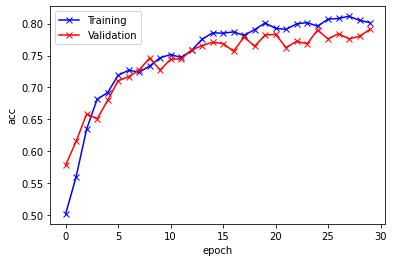

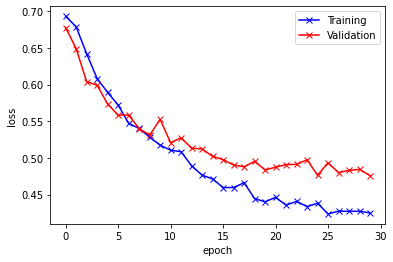

In [57]:
def plot_history(history):
    
    train_acc = [x.get('acc') for x in history]
    val_acc = [x['val_acc'] for x in history]
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend(['Training', 'Validation'])
   
    
    plt.figure()
    train_losses = [x.get('loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    
plot_history(history)

In [59]:
test_epoch_acc=0
test_epoch_loss=0
for test_img,test_lbl in test_set:
    

    test_img, test_lbl = test_img.to(device), test_lbl.to(device)
            
    test_output = model(test_img)
            
    test_loss = criterion(test_output, test_lbl)
    test_acc = accuracy(test_output, test_lbl)
            
            
    test_epoch_acc += test_acc.item()/len(test_set)
    test_epoch_loss += test_loss.item()/len(test_set)
            
result={'test_loss': test_epoch_loss, 'test_acc': test_epoch_acc}
print(" test_loss: {:.4f}, test_acc: {:.4f}".format(result['test_loss'], result['test_acc']))

 test_loss: 0.4515, test_acc: 0.7922
